# HPO (Hyper Parameter Optimization)
- 최적의 학습 모델을 구현하기 위해 사용자가 지정해주는 값
> 설정한 하이퍼 파라미터 값에 따라 모델의 성능이 달라지기 때문에 파라미터 값을 조정하여 최적의 조합을 찾는 것이 매우 중요

In [4]:
#!pip install lightgbm
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score

%matplotlib inline

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

Data load

In [16]:
import seaborn as sns

df = sns.load_dataset('titanic') # 타이타닉 데이터 받아오기
cols = ["age","sibsp","parch","fare"] # 숫자니까 바로 사용
features = df[cols] # 피쳐
target = df["survived"] # 정답값

Data Encoding

In [18]:
from sklearn.preprocessing import OneHotEncoder

cols = ["pclass","sex","embarked"] # 범주형

enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

features = pd.concat([features,tmp],axis=1)

Missing data

In [19]:
features.age = features.age.fillna(features.age.median())

Data Scaling

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

Train_Test_Split

In [21]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state=42

X_tr, X_te, y_tr, y_te = train_test_split(
    features, target, test_size=0.20,
    shuffle=True, random_state=random_state)

X_tr.shape, X_te.shape

((712, 13), (179, 13))

검증

In [22]:
n_iter=50
num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

In [24]:
def print_scores(y_te,pred):
    print(confusion_matrix(y_te, pred))
    print('-'*50)
    print(classification_report(y_te, pred))

In [26]:
from lightgbm.sklearn import LGBMClassifier

## Grid Search
- 특정 하이퍼 파라미터 구간에서 일정 간격으로 값을 선택하여, 선택된 모든 값을  탐색하는 최적해를 찾는 가장 기본적이고 간단한 HPO 기법
- 구간 전역을 탐색하기 때문에 탐색 시간이 오래 걸리고, 균일한 간격으로 탐색하기 때문에 최적해를 찾지 못하는 경우가 발생할 수 있음

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이 
    "criterion" : ["gini","entropy"], # 순수도 척도
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}
model = LGBMClassifier(random_state=random_state)

gs=GridSearchCV(model, hp, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=False).fit(X_tr,y_tr)

[LightGBM] [Warning] Unknown parameter: criterion


In [30]:
#best params
gs.best_params_   

{'criterion': 'gini',
 'learning_rate': 0.001,
 'max_depth': 6,
 'n_estimators': 1100}

In [31]:
gs.best_score_

0.8389356255214173

In [32]:
gs.score(X_te,y_te)

0.8875160875160876

In [33]:
pred = gs.best_estimator_.predict(X_te)   #best model
print_scores(y_te, pred)

[[94 11]
 [26 48]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       105
           1       0.81      0.65      0.72        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



best params를 사용해서 모델을 학습시키기!

<AxesSubplot:xlabel='param_criterion', ylabel='param_n_estimators'>

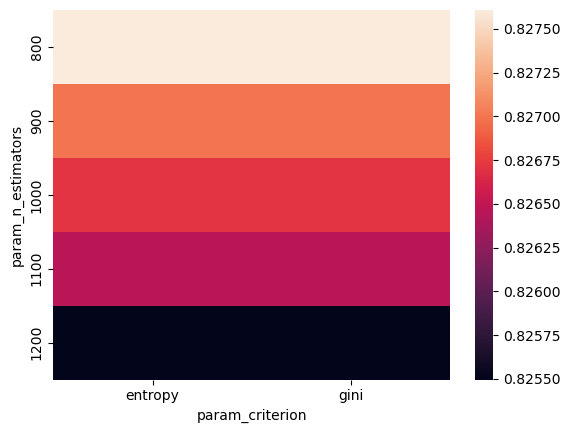

In [35]:
table = pd.pivot_table(pd.DataFrame(gs.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

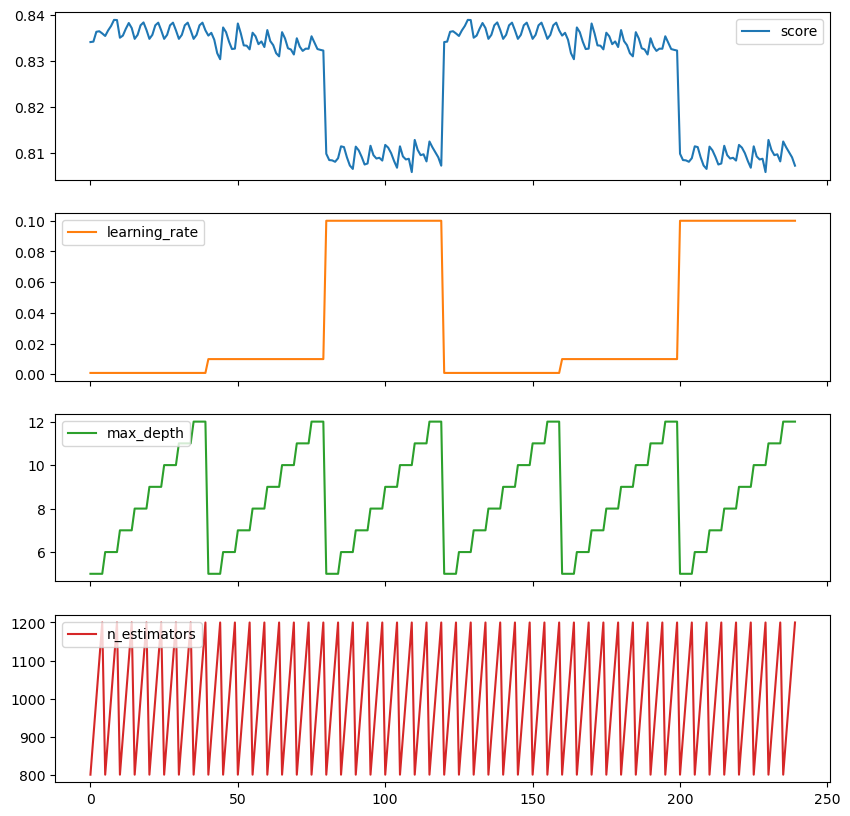

In [43]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_learning_rate'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

## Random Search
- 탐색 구간 안에서 임의로 파라미터 값을 선택
- 그리드 서치의 문제점을 보완하기 위해 고안된 기법

In [37]:
from sklearn.model_selection import RandomizedSearchCV

In [38]:
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "criterion" : ["gini","entropy"], # 순수도 척도
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}
model = LGBMClassifier(random_state=random_state)

rs=RandomizedSearchCV(model, hp, scoring='roc_auc', n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False).fit(X_tr,y_tr)
rs.best_score_, rs.score(X_te,y_te)

[LightGBM] [Warning] Unknown parameter: criterion


(0.8383827919158889, 0.8879665379665379)

In [39]:
pred = rs.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

0.8879665379665379

In [40]:
pred = rs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[[94 11]
 [26 48]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       105
           1       0.81      0.65      0.72        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



<AxesSubplot:xlabel='param_criterion', ylabel='param_n_estimators'>

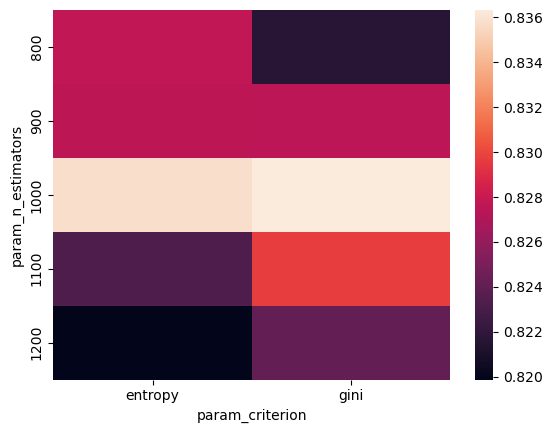

In [41]:
table = pd.pivot_table(pd.DataFrame(rs.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

> Grid search에서는 entropy랑 gini가 차이없다고 나왔는데 random에서는 차이가 있다고 나옴
>> random이 변별력이 더 강함을 알 수 있다.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

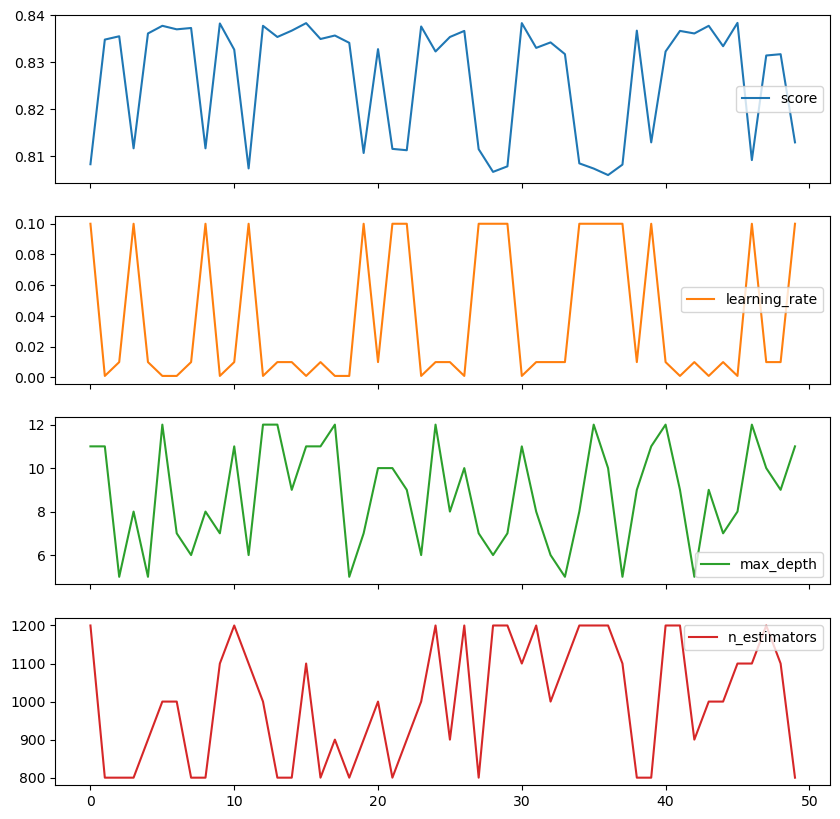

In [44]:
rs_results_df=pd.DataFrame(np.transpose([rs.cv_results_['mean_test_score'],
                                         rs.cv_results_['param_learning_rate'].data,
                                         rs.cv_results_['param_max_depth'].data,
                                         rs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

Text(0, 0.5, 'best_cumulative_score')

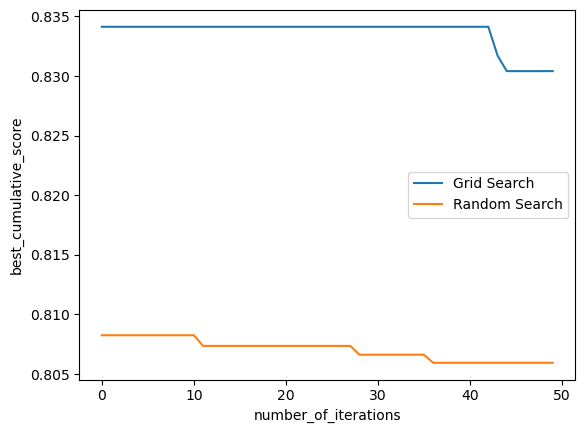

In [45]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()

ax = scores_df.plot()
ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")